In [45]:
# import all the things!
# yeah I know I don't need all this, but just incase...

import pandas as pd
import numpy as np
import os
%pwd
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.preprocessing import LabelEncoder
from sklearn.cross_validation import cross_val_score, StratifiedKFold
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor, ExtraTreesRegressor, ExtraTreesClassifier, BaggingRegressor,BaggingClassifier
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.ensemble import AdaBoostClassifier, AdaBoostRegressor, GradientBoostingRegressor ,GradientBoostingClassifier
from sklearn.externals.six import StringIO
from sklearn.tree import export_graphviz
import pydot
from IPython.display import Image
from sklearn.cross_validation import train_test_split
from sklearn.grid_search import GridSearchCV
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD
from sklearn.naive_bayes import GaussianNB, BernoulliNB, MultinomialNB
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import roc_curve, auc

In [2]:
# need to import df csv

df = pd.read_csv('gender_included_df.csv', encoding='utf-8')

/Users/Driz/anaconda2/lib/python2.7/site-packages/IPython/core/interactiveshell.py:2723: DtypeWarning: Columns (4,5,6,13) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [4]:
df.head(3)

,id,episode_id,number,raw_text,timestamp_in_ms,speaking_line,character_id,location_id,raw_character_text,raw_location_text,spoken_words,normalized_text,word_count,gender
0,9549,32,209,"Miss Hoover: No, actually, it was a little of ...",848000,True,464,3.0,Miss Hoover,Springfield Elementary School,"No, actually, it was a little of both. Sometim...",no actually it was a little of both sometimes ...,31.0,f
1,9550,32,210,Lisa Simpson: (NEAR TEARS) Where's Mr. Bergstrom?,856000,True,9,3.0,Lisa Simpson,Springfield Elementary School,Where's Mr. Bergstrom?,wheres mr bergstrom,3.0,f
2,9551,32,211,Miss Hoover: I don't know. Although I'd sure l...,856000,True,464,3.0,Miss Hoover,Springfield Elementary School,I don't know. Although I'd sure like to talk t...,i dont know although id sure like to talk to h...,22.0,f


In [5]:
# create new df reducing to column for further preprocessing and my y-column
# now here I may want to make another df and include 'location_id', 'word_count' 
# I feel 'word_count' may be a huge impact (female characters have lower count than male--EDA)

df_reduced = df.copy()[['normalized_text','gender']]

df_expanded = df.copy()[['location_id', 'word_count', 'normalized_text', 'gender']]

In [6]:
df_reduced.dropna(inplace=True)
df_reduced.head()

,normalized_text,gender
0,no actually it was a little of both sometimes ...,f
1,wheres mr bergstrom,f
2,i dont know although id sure like to talk to h...,f
3,that life is worth living,f
4,the polls will be open from now until the end ...,f


In [7]:
df_expanded.dropna(inplace=True)
df_expanded.head()

,location_id,word_count,normalized_text,gender
0,3.0,31.0,no actually it was a little of both sometimes ...,f
1,3.0,3.0,wheres mr bergstrom,f
2,3.0,22.0,i dont know although id sure like to talk to h...,f
3,3.0,5.0,that life is worth living,f
4,3.0,33.0,the polls will be open from now until the end ...,f


In [12]:
len(df_reduced)

92692

In [8]:
df_reduced['gender'].value_counts()

m    68650
f    24042
Name: gender, dtype: int64

In [11]:
# get baseline no. of female / no. of total rows

np.mean(df_reduced['gender'] == 'f')

0.25937513485521946

In [13]:
df_expanded['gender'].value_counts()

m    68435
f    24003
Name: gender, dtype: int64

In [14]:
# get baseline no. of female / no. of total rows

np.mean(df_expanded['gender'] == 'f')

0.25966593825050305

In [20]:
# need to pull out dependent variable (y)

y = LabelEncoder().fit_transform(df_reduced['gender'].values)

In [21]:
# need to pull out dependent variable (y)

y_ex = LabelEncoder().fit_transform(df_expanded['gender'].values)

In [22]:
# set up train test split
# do on reduced first then go back to expanded if time

x_train, x_test, y_train, y_test = train_test_split(df_reduced, y)

In [23]:
# check shape of train test split

print x_train.shape
print x_test.shape
print y_train.shape
print y_test.shape

(69519, 2)
(23173, 2)
(69519,)
(23173,)


In [39]:
# need to run train test split through tfidf to fit data and then transform it and transform test data off of learned train data

# picked ngram=1,3 just cause I like that option and it seems to produce well
tfidf = TfidfVectorizer(stop_words='english',
                       ngram_range=(1,3))
# based off of explained variance ratio graph in hyperparam notebook
tsvd = TruncatedSVD(n_components=700)


tfidf.fit(x_train.normalized_text.values)
transformed = tfidf.transform(x_train.normalized_text.values)


tsvd.fit(transformed)
x_train_transformed = tsvd.transform(transformed)

x_test_transformed = tfidf.transform(x_test.normalized_text.values)
x_test_transformed = tsvd.transform(x_test_transformed)

In [40]:
print x_train_transformed.shape
print x_test_transformed.shape
print y_train.shape
print y_test.shape

(69519, 700)
(23173, 700)
(69519,)
(23173,)


In [41]:
# random forest params came from a stalled GridSearchCV in hyperparam notebook
rf = RandomForestClassifier(max_features=0.75, max_leaf_nodes=10,
                            max_depth=20, n_jobs=-1)
rf.fit(x_train_transformed, y_train)
predictions = rf.predict(x_test_transformed)
rf.score(x_test_transformed, y_test)

0.7473784145341561

In [42]:
confusion = pd.DataFrame(confusion_matrix(y_test, predictions), columns=['predicted_f', 'predicted_m'], index=['is_f', 'is_m'])
confusion

,predicted_f,predicted_m
is_f,478,5555
is_m,299,16841


In [43]:
print "Classification Report:\n", classification_report(y_test, predictions)

Classification Report:
             precision    recall  f1-score   support

          0       0.62      0.08      0.14      6033
          1       0.75      0.98      0.85     17140

avg / total       0.72      0.75      0.67     23173



In [46]:
## plots ROC curve
def plot_roc(x_test_transformed, y_test, model):
    fpr, tpr, _ = roc_curve(y_test, model.predict_proba(x_test)[:,1])
    roc_auc = auc(fpr, tpr)
    print 'ROC AUC: %0.2f' % roc_auc
    plt.figure()
    plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve')
    plt.legend(loc="lower right")
    plt.show()
    
plot_roc(x_test_transformed, y_test, rf)    

ValueError: could not convert string to float: m

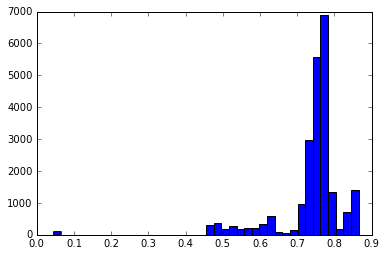

In [47]:
# taking a look at predictions to visualize where to alter probability cutoff

predict = rf.predict_proba(x_test_transformed)

plt.hist(predict[:,1], bins=40);

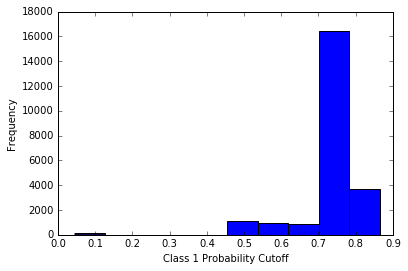

In [48]:
## plots the distribution of prediction probabilities for the 1 class
def plot_proba(x_test, model):
    predict = model.predict_proba(x_test)
    plt.hist(predict[:,1])
    plt.ylabel('Frequency')
    plt.xlabel('Class 1 Probability Cutoff')
    plt.show()
    
plot_proba(x_test_transformed, rf)

In [49]:
## calculates new scores based on inputed probability, then plots new model scores based on the range of cutoffs

def get_predictions(model, x_test, y_test, probability):
    predict = model.predict_proba(x_test)
    new_predictions = []
    for i in predict:
        if i[1] >= probability:
            new_predictions.append(1)
        else:
            new_predictions.append(0)
    return new_predictions
    
def find_optimal_probability(model, x_test, y_test):
    probabilities = range(1,101)
    new_probabilities = []
    for i in probabilities:
        new_probabilities.append(float(i)/100)
    range_of_scores = []
    for i in new_probabilities:
        new_preds = get_predictions(model, x_test, y_test, i)
        cmatrix = confusion_matrix(y_test, new_preds)
        new_model_score = (cmatrix[0,0] + cmatrix[1,1])/float(np.sum(cmatrix))
        range_of_scores.append(new_model_score)
    plt.plot(new_probabilities, range_of_scores)
    plt.xlabel("Probability Cutoff")
    plt.ylabel("Model Score")
    plt.show()

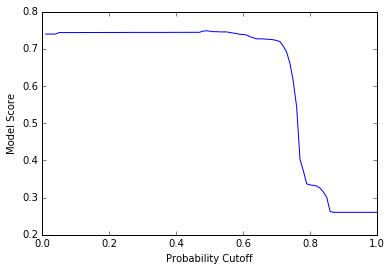

In [53]:
# need to change probability .75

get_predictions(rf, x_test_transformed, y_test, .75)
find_optimal_probability(rf, x_test_transformed, y_test)

Confusion Matrix:
           predicted_female  predicted_male
is_female              2815            3218
is_male                5770           11370

Classification Report:
             precision    recall  f1-score   support

          0       0.33      0.47      0.39      6033
          1       0.78      0.66      0.72     17140

avg / total       0.66      0.61      0.63     23173



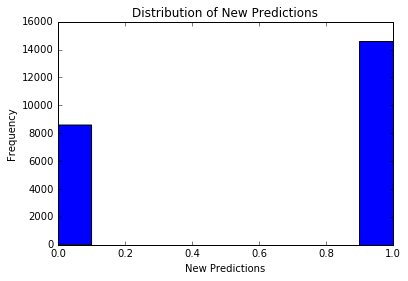

In [54]:
def tune_predictions(model, x_test, y_test, probability):
    predict = model.predict_proba(x_test)
    new_predictions = []
    for i in predict:
        if i[1] >= probability:
            new_predictions.append(1)
        else:
            new_predictions.append(0)
    print "Confusion Matrix:\n", pd.DataFrame(confusion_matrix(y_test, new_predictions), 
                                              columns=['predicted_female', 'predicted_male'], index=['is_female', 'is_male'])
    print "\nClassification Report:\n", classification_report(y_test, new_predictions)
    plt.hist(new_predictions)
    plt.xlabel('New Predictions')
    plt.ylabel('Frequency')
    plt.title('Distribution of New Predictions')
    plt.show()
    
tune_predictions(rf, x_test_transformed, y_test, .75)

In [62]:
confusion_tuned = pd.DataFrame(confusion_matrix(y_test, new_predictions), columns=['predicted_f', 'predicted_m'], index=['is_f', 'is_m'])
confusion_tuned

NameError: name 'new_predictions' is not defined

In [ ]:
# maybe insert model function here